In [46]:
%matplotlib inline
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [47]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

In [48]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [49]:
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
        
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ])
    image = in_transform(image).unsqueeze(0)
    
    return image
    

In [188]:
content = load_image('paris/fullsizeoutput_1303b.jpeg').to(device)
#content = load_image('Images/MonaLisa.jpg').to(device)
style = load_image('Images/StarryNight.jpg', shape=content.shape[-2:]).to(device)

In [189]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.squeeze()
    image = image.transpose(1, 2, 0)
    #print(image.shape)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

(-0.5, 399.5, 599.5, -0.5)

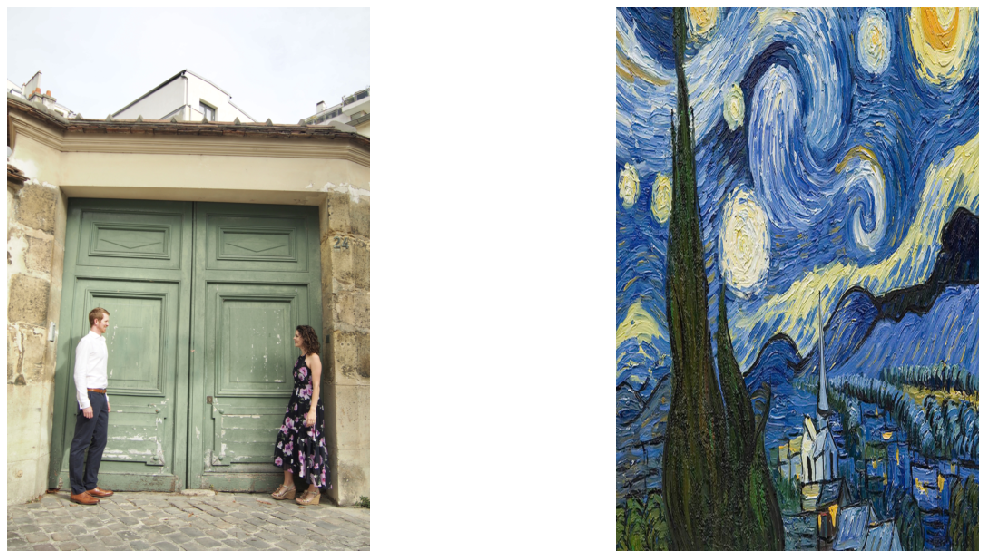

In [190]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')

In [191]:
def get_features(image, model):
    
    layers = {'0': 'conv1_1',
              '5': 'conv2_1', 
              '10': 'conv3_1', 
              '19': 'conv4_1',
              '21': 'conv4_2', #content extraction (the more you follow through the network, the more prominent the content gets)
              '28': 'conv5_1'}
    
    features = {}
    
    for name, layer in model._modules.items():
        image = layer(image)
        if name in layers:
            features[layers[name]] = image
    
    return features

In [192]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [193]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h*w) # now we have a 2D tensor
    gram = torch.mm(tensor, tensor.t())
    return gram

In [194]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [195]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1 #alpha
style_weight = 1e6 #beta

In [196]:
target = content.clone().requires_grad_(True).to(device)

In [197]:
show_every = 300
optimizer = optim.Adam([target], lr=0.003)
steps = 9900

height, width, channels = im_convert(target).shape
image_array = np.empty(shape=(300, height, width, channels))
capture_frame = steps/300 # capture 1 every seven steps
counter = 0

Total loss:  3197629.75
Iteration:  300


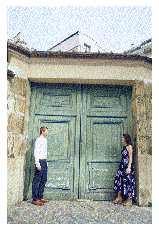

Total loss:  997860.5
Iteration:  600


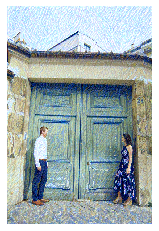

Total loss:  624385.8125
Iteration:  900


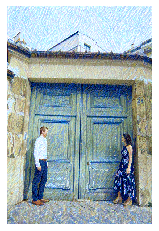

Total loss:  510013.65625
Iteration:  1200


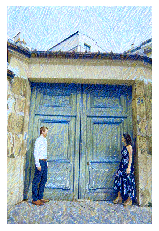

Total loss:  436034.15625
Iteration:  1500


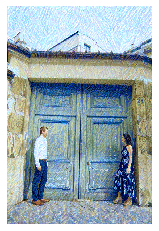

Total loss:  378565.6875
Iteration:  1800


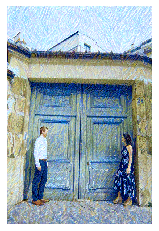

Total loss:  331270.0
Iteration:  2100


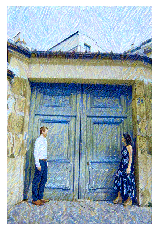

Total loss:  291009.0625
Iteration:  2400


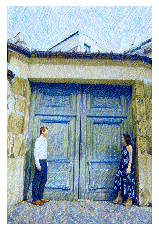

Total loss:  255815.953125
Iteration:  2700


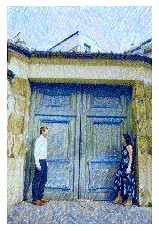

Total loss:  224667.453125
Iteration:  3000


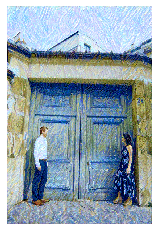

Total loss:  196859.546875
Iteration:  3300


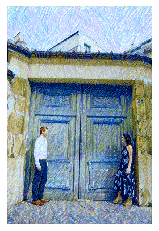

Total loss:  171727.03125
Iteration:  3600


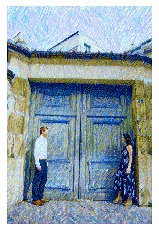

Total loss:  148907.734375
Iteration:  3900


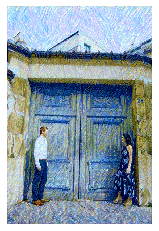

Total loss:  128117.9921875
Iteration:  4200


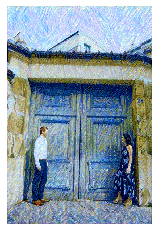

Total loss:  109290.0078125
Iteration:  4500


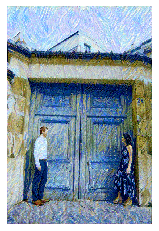

Total loss:  92346.390625
Iteration:  4800


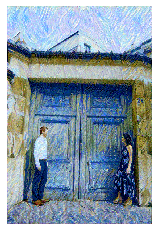

Total loss:  77264.1875
Iteration:  5100


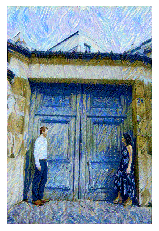

Total loss:  64054.51171875
Iteration:  5400


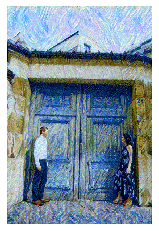

Total loss:  52745.1796875
Iteration:  5700


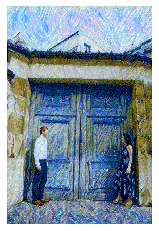

Total loss:  43359.69921875
Iteration:  6000


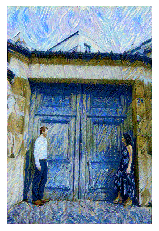

Total loss:  35937.16796875
Iteration:  6300


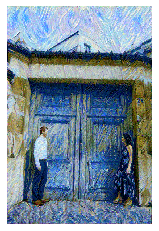

Total loss:  29896.591796875
Iteration:  6600


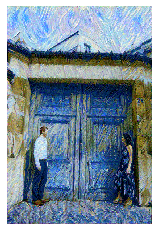

Total loss:  25096.685546875
Iteration:  6900


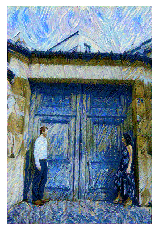

Total loss:  22103.66796875
Iteration:  7200


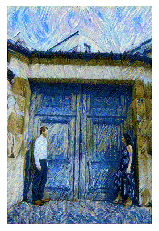

Total loss:  18901.080078125
Iteration:  7500


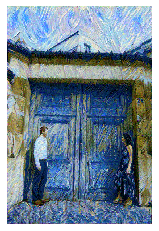

Total loss:  17431.814453125
Iteration:  7800


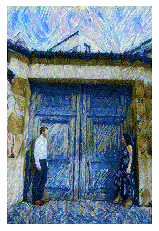

Total loss:  15418.583984375
Iteration:  8100


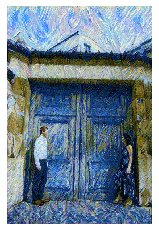

Total loss:  14250.3466796875
Iteration:  8400


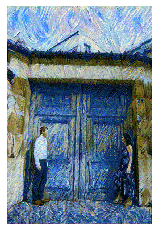

Total loss:  13043.7685546875
Iteration:  8700


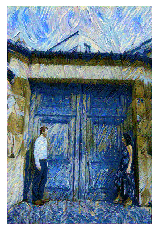

Total loss:  12324.5751953125
Iteration:  9000


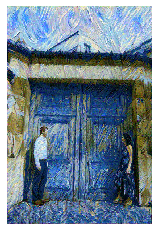

Total loss:  12506.935546875
Iteration:  9300


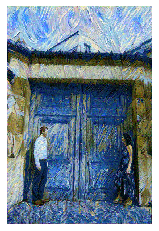

Total loss:  11329.2265625
Iteration:  9600


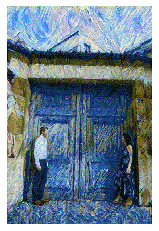

Total loss:  10703.658203125
Iteration:  9900


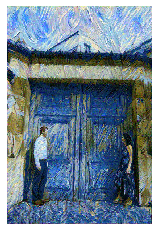

In [198]:
for ii in range(1, steps+1):
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    style_loss = 0
    for layer in style_weights:  #must iterate through all of the style layers to get the style loss
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        _, d, h, w = target_feature.shape
        style_loss += layer_style_loss / (d * h * w)
    
    total_loss = content_loss * content_weight + style_loss * style_weight
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # add output for data visualizing
    if ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        print('Iteration: ', ii)
        plt.imshow(im_convert(target))
        plt.axis('off')
        plt.show()
    if ii % capture_frame == 0:
        image_array[counter] = im_convert(target)
        counter = counter + 1
        

(-0.5, 399.5, 599.5, -0.5)

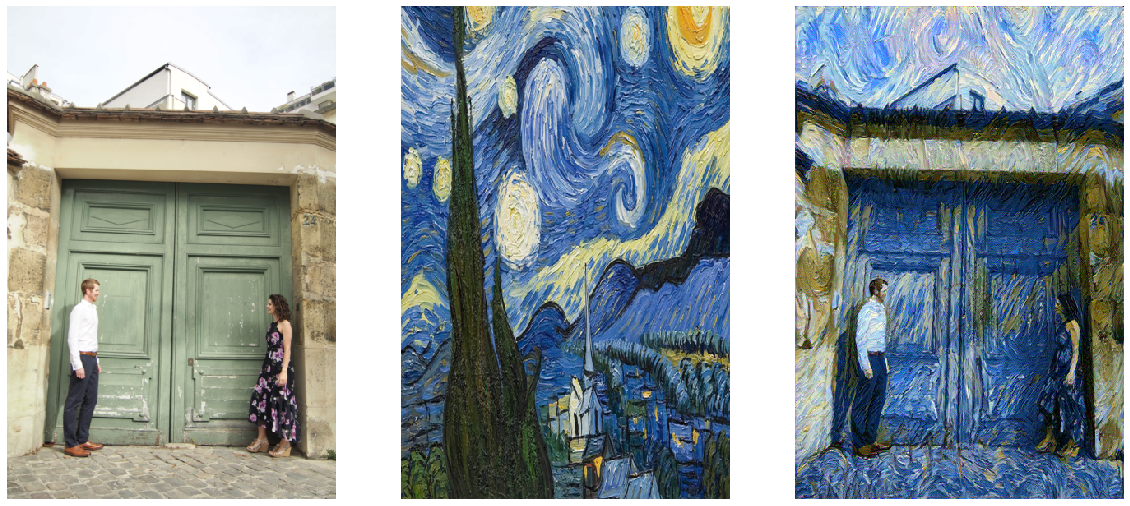

In [199]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')
ax3.imshow(im_convert(target))
ax3.axis('off')

In [200]:
import cv2

frame_height, frame_width, _ = im_convert(target).shape
vid = cv2.VideoWriter('rae_dae_doors_starry.mp4', cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height))
#
 #   img = image_array[i]
  #  img = img*255
   # img = np.array(img, dtype = np.uint8)
   # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
   # vid.write(img)

for i in range(0, 300):
    img = image_array[i]
    img = img*255
    img = np.array(img, dtype = np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    vid.write(img)

vid.release()